In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
columns = inspect(engine).get_columns('Station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


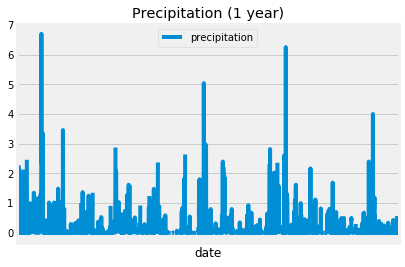

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() # '2017-08-23'
max_date[0] # '2017-08-23'
 
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(max_date[0], "%Y-%m-%d") - dt.timedelta(days=366) # datetime.datetime(2016, 8, 22, 0, 0)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all() # list

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
precipitation_df= precipitation_df.set_index("date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation (1 year)")
plt.legend(loc='upper center')
plt.tight_layout()
plt.xticks([])
plt.savefig("Figures/Precipitation.png")
plt.show()

In [12]:
type(max_date)

sqlalchemy.util._collections.result

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print(f"{stations} stations available.")

9 stations available.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
most_active_id = active_stations[0][0] #'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature_data_top = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_id).filter(Measurement.date > year_ago).order_by(Measurement.date).all()

temperature_list = []
for i in range(len(temperature_data_top)):
    temperature_list.append(temperature_data_top[i][2])

    
#temp_data_top[0][2]
active_st_temperature = [min(temperature_list), max(temperature_list), np.mean(temperature_list)]
active_st_temperature

[59.0, 83.0, 73.10795454545455]

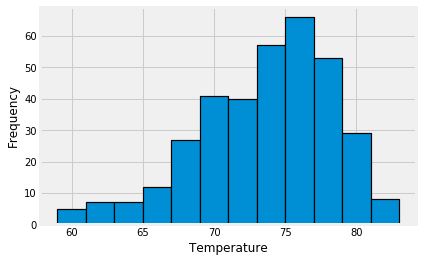

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Plot the results as a histogram with `bins=12'
plt.hist(x = temperature_list, bins = 12, edgecolor='black', linewidth=1.2)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("Figures/Active_station_temps.png")
plt.show()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_stats_list = calc_temps("2017-05-03", "2017-05-16")
print(temp_stats_list)

[(66.0, 75.38461538461539, 80.0)]


In [21]:
trip_temp_df = pd.DataFrame(temp_stats_list, columns=['min_temp', 'avg_temp', 'max_temp'])
trip_temp_df

,min_temp,avg_temp,max_temp
0,66.0,75.384615,80.0


<Figure size 144x360 with 0 Axes>

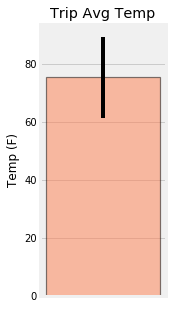

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure(figsize=(2,5))
tmin = temp_stats_list[0][0]
tavg = temp_stats_list[0][1]
tmax = temp_stats_list[0][2]
y_err = tmax-tmin

plt.figure(figsize=(2,5))
plt.bar(0,tavg,yerr=y_err,align="center",width=1,color="coral",alpha=0.5,edgecolor='black', linewidth=1.2)
plt.xticks([])
plt.ylim=(0,120)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.savefig("Figures/Trip_avg_temperature.png")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
select = [Measurement.station, func.sum(Measurement.prcp),  Station.name, Station.latitude, Station.longitude, Station.elevation]

trip_data_stations = session.query(*select).filter(Measurement.station == Station.station).\
                       filter(Measurement.date>= "2017-05-03" ).filter(Measurement.date <= "2017-05-16" ).\
                       group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()


print(trip_data_stations)

[('USC00516128', 4.5600000000000005, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00519281', 3.09, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00513117', 2.2199999999999998, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00514830', 1.95, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519523', 0.8, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00519397', 0.07, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

# funcion to make a list of dates in format %m-%d. 

def list_dates(date1, date2):
    start_date = dt.datetime.strptime(date1, "%Y-%m-%d")
    end_date = dt.datetime.strptime(date2, "%Y-%m-%d")
    dt_list = []
    
    datetime_list = [date.fromordinal(i) for i in range(start_date.toordinal(), end_date.toordinal()+1)]

    for i in range(len(datetime_list)):
        # Pass a date string and a code for interpreting it.
        new_datetime = dt.datetime.strptime(str(datetime_list[i]), '%Y-%m-%d')
        # Turn a datetime into a date string.
        datestr = new_datetime.strftime('%m-%d') # can cjange to any format
        # append date to list
        dt_list.append(datestr)
    return dt_list

# plug in the start and end dates into my function to get list of dates
temp_normals_list = list_dates("2017-05-03", "2017-05-16")

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []

for i in range(len(temp_normals_list)):
    a = daily_normals(temp_normals_list[i])
    normals.append(a)

normals

[[(67.0, 73.41071428571429, 84.0)],
 [(65.0, 73.59649122807018, 78.0)],
 [(67.0, 73.39655172413794, 79.0)],
 [(66.0, 73.14035087719299, 80.0)],
 [(64.0, 71.78846153846153, 79.0)],
 [(65.0, 72.18867924528301, 80.0)],
 [(67.0, 72.9322033898305, 79.0)],
 [(64.0, 73.3157894736842, 78.0)],
 [(65.0, 73.61111111111111, 79.0)],
 [(65.0, 73.13793103448276, 79.0)],
 [(67.0, 73.14285714285714, 79.0)],
 [(63.0, 73.89285714285714, 80.0)],
 [(63.0, 73.69090909090909, 79.0)],
 [(68.0, 74.37931034482759, 80.0)]]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# add year back to every list item. [or could change above function to give different format. ]
full_dates_list = ["2017-" + item for item in temp_normals_list]
daily_norms_df = pd.DataFrame(columns=['min_temp', 'avg_temp', 'max_temp'])

# Create a dataframe from the previous query 
for i in range(len(normals)):
    daily_norms_df = daily_norms_df.append(pd.DataFrame(normals[i], columns=['min_temp', 'avg_temp', 'max_temp']))

# Add trip_dates to Pandas DataFrame and declare it as Pandas datetime class
# pandas.core.indexes.datetimes.DatetimeIndex
daily_norms_df['date'] = pd.to_datetime(full_dates_list, format='%Y-%m-%d')

# Set index to date
daily_norms_df.set_index('date',inplace=True)

daily_norms_df

,min_temp,avg_temp,max_temp
date,,,
2017-05-03,67.0,73.410714,84.0
2017-05-04,65.0,73.596491,78.0
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0
2017-05-10,64.0,73.315789,78.0
2017-05-11,65.0,73.611111,79.0


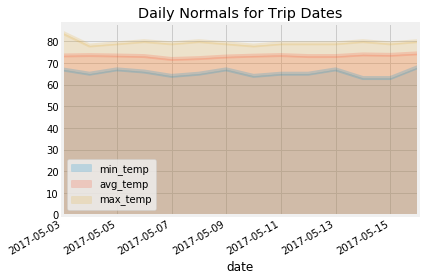

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Figures/Daily_norms_for_trip.png")
plt.show()